### 請解壓縮data.rar與darknet53.conv.rar，取得本程式之訓練數據與backbone network

In [1]:
! nvidia-smi

Sun Oct 25 01:33:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! git clone https://github.com/pjreddie/darknet.git
! cd darknet; head Makefile

Cloning into 'darknet'...
remote: Enumerating objects: 5913, done.
remote: Total 5913 (delta 0), reused 0 (delta 0), pack-reused 5913
Receiving objects: 100% (5913/5913), 6.34 MiB | 29.63 MiB/s, done.
Resolving deltas: 100% (3916/3916), done.
GPU=0
CUDNN=0
OPENCV=0
OPENMP=0
DEBUG=0

ARCH= -gencode arch=compute_30,code=sm_30 \
      -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52]


In [3]:
! sed -i "s/GPU=0/GPU=1/g" /content/darknet/Makefile
! sed -i "s/CUDNN=0/CUDNN=1/g" /content/darknet/Makefile
! sed -i "s/OPENCV=0/OPENCV=1/g" /content/darknet/Makefile

In [4]:
! head /content/darknet/Makefile

GPU=1
CUDNN=1
OPENCV=1
OPENMP=0
DEBUG=0

ARCH= -gencode arch=compute_30,code=sm_30 \
      -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52]


In [5]:
! cd darknet; make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN  -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -c ./src/gemm.c -o obj/gemm.o
./src/gemm.c: In function ‘time_gpu’:
./src/gemm.c:232:9: warning: ‘cudaThreadSynchronize’ is deprecated [-Wdeprecated-declarations]
         cudaThreadSynchronize();
         ^~~~~~~~~~~~~~~~~~~~~
In file included from /usr/local/cuda/include/cuda_runtime.h:96:0,
                 from include/darknet.h:11,
                 from ./src/utils.h:5,
                 from ./src/gemm.c:2:
/usr/local/cuda/include/cuda_runtime_api.h:957:57: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadSynchronize(void);
                                                         ^~~~~~~~~~~~~~~~~~~~~
gcc -Iinclude/ -Isrc/ -DOPENCV `pkg-config --cflags opencv`  -DGPU -I/usr/local/cuda/include/ -DCUDNN 

In [6]:
from google.colab import drive
import os
from PIL import Image
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
! rm -rf /content/cfg_mask
! mkdir /content/cfg_mask

In [8]:
datasets = []
for f in os.listdir('/content/drive/My Drive/yolo_mask_detection/yolo'):
    if f.split('.')[-1] == 'jpg':
        datasets.append('/content/drive/My Drive/yolo_mask_detection/yolo/' + f)

In [9]:
# 訓練集
f = open('/content/cfg_mask/train.txt' , 'w')
f.write('\n'.join(datasets[0:670]))

38079

In [10]:
# 測試集
f = open('/content/cfg_mask/test.txt' , 'w')
f.write('\n'.join(datasets[670:]))

398

In [11]:
! cp '/content/drive/My Drive/yolo_mask_detection/obj.data' cfg_mask/
! cp '/content/drive/My Drive/yolo_mask_detection/obj.names' cfg_mask/
! cp /content/darknet/cfg/yolov3.cfg /content/cfg_mask/
! cp "/content/drive/My Drive/yolo_mask_detection/darknet53.conv.74" /content/cfg_mask/
! mkdir /content/cfg_mask/weights

In [14]:
! sed -n -e 603p -e 610p -e 689p -e 696p -e 776p -e 783p /content/cfg_mask/yolov3.cfg

filters=255
classes=80
filters=255
classes=80
filters=255
classes=80


In [15]:
! sed -i '603s/255/24/' /content/cfg_mask/yolov3.cfg
! sed -i '610s/80/3/' /content/cfg_mask/yolov3.cfg
! sed -i '689s/255/24/' /content/cfg_mask/yolov3.cfg
! sed -i '696s/80/3/' /content/cfg_mask/yolov3.cfg
! sed -i '776s/255/24/' /content/cfg_mask/yolov3.cfg
! sed -i '783s/80/3/' /content/cfg_mask/yolov3.cfg

<img src="示意圖.jpg" width="60%">

YOLOV3 的最後輸出的Feature Map的數量 ➞ (4 ✚ 1 ✚ Class) ✖ Box <br>
*  Box 是每種 Feature Map 的 Anchor Box 數量  <br>
*  4 是 Anchor Box 中的 x y w h   <br>
*  1 是 Anchor Box 中的 Confidence <br>
*  Class 是種類數量  <br>
*  第1種 Feature Map ➞ 13 ✕ 13  <br>
*  第2種 Feature Map ➞ 26 ✕ 26  <br>
*  第3種 Feature Map ➞ 52 ✕ 52  <br>
*  Feature Map 越小，感受野越大，對大目標越敏感<br>
*  Feature Map 越大，感受野越小，對小目標越敏感<br>
*  因此本程式中每1種 Feature Map 的輸出都會有24個

In [16]:
# 本程式中只有3個種類
# 1. 口罩有戴好       ⇨ mask
# 2. 沒戴口罩         ⇨ no mask
# 3. 沒確實戴好口罩    ⇨ bad
# 因此這裡需要改參數
! sed -n -e 603p -e 689p -e 776p -e 610p -e 696p -e 783p /content/cfg_mask/yolov3.cfg

filters=24
classes=3
filters=24
classes=3
filters=24
classes=3


In [18]:
! darknet/darknet detector train /content/cfg_mask/obj.data /content/cfg_mask/yolov3.cfg /content/cfg_mask/darknet53.conv.74 | grep avg, 

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

In [19]:
! rm -rf /content/test
! mkdir /content/test

In [20]:
! cp '/content/drive/My Drive/yolo_mask_detection/test_image_1.jpg' test/
! cp '/content/drive/My Drive/yolo_mask_detection/test_image_2.jpg' test/
! cp '/content/drive/My Drive/yolo_mask_detection/test_image_3.jpg' test/
! cp '/content/drive/My Drive/yolo_mask_detection/test_image_4.jpg' test/

In [21]:
! cd darknet; ./darknet detector test /content/cfg_mask/obj.data  /content/cfg_mask/yolov3.cfg /content/cfg_mask/weights/yolov3.backup /content/test/test_image_1.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

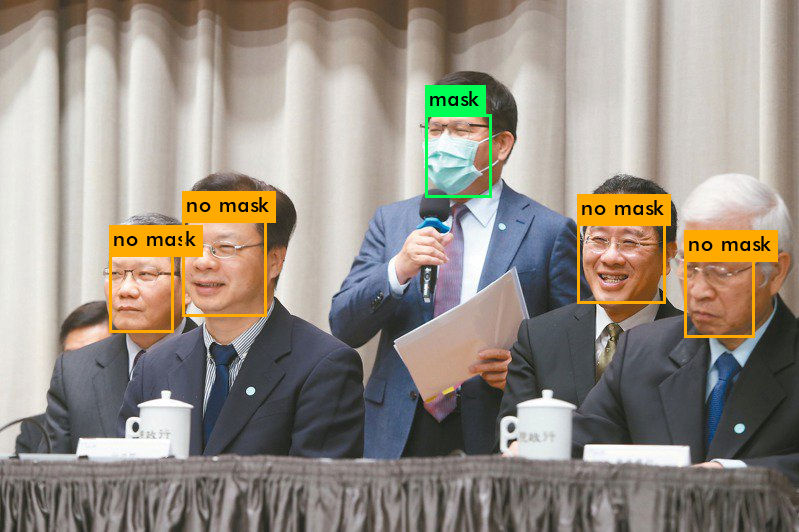

In [22]:
Image.open('/content/darknet/predictions.jpg')

In [23]:
! cd darknet; ./darknet detector test /content/cfg_mask/obj.data  /content/cfg_mask/yolov3.cfg /content/cfg_mask/weights/yolov3.backup /content/test/test_image_2.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

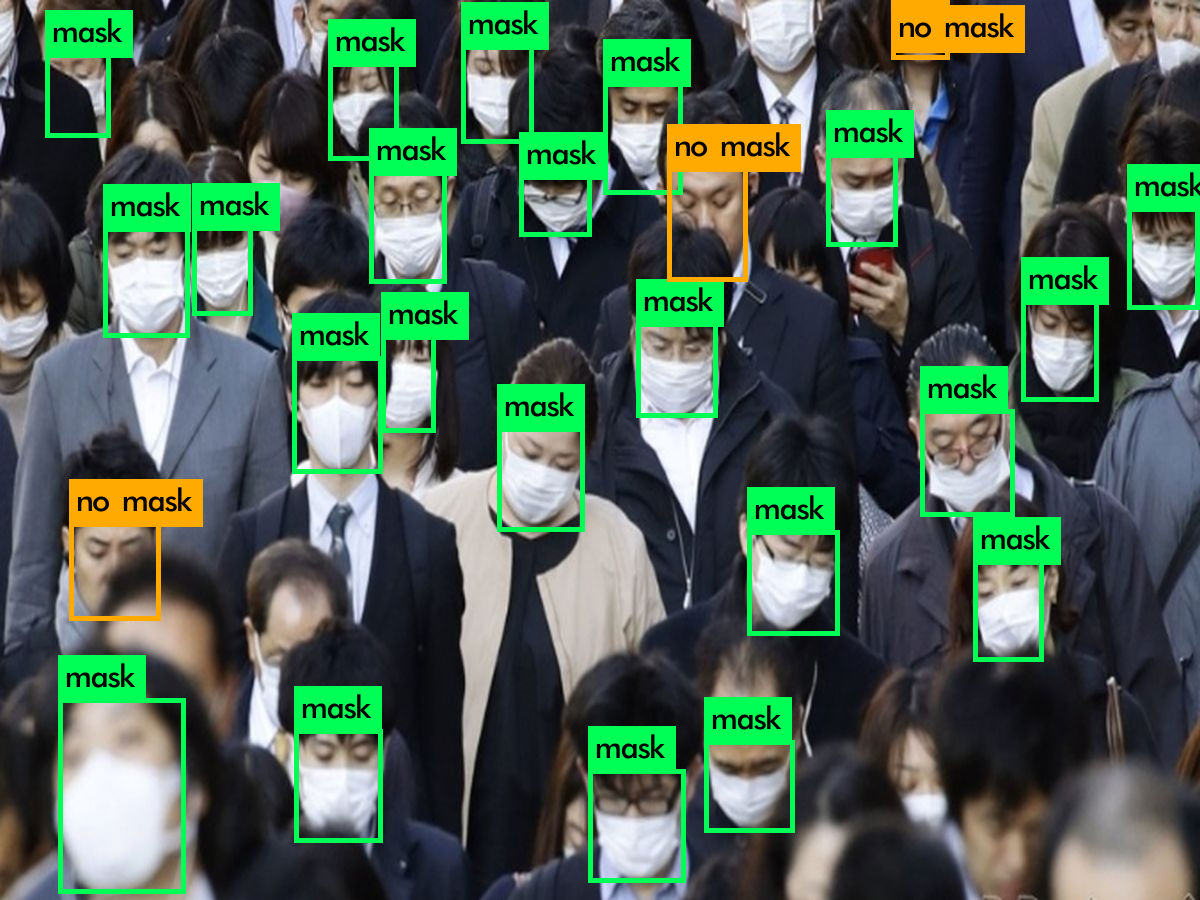

In [24]:
Image.open('/content/darknet/predictions.jpg')

In [25]:
! cd darknet; ./darknet detector test /content/cfg_mask/obj.data  /content/cfg_mask/yolov3.cfg /content/cfg_mask/weights/yolov3.backup /content/test/test_image_3.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

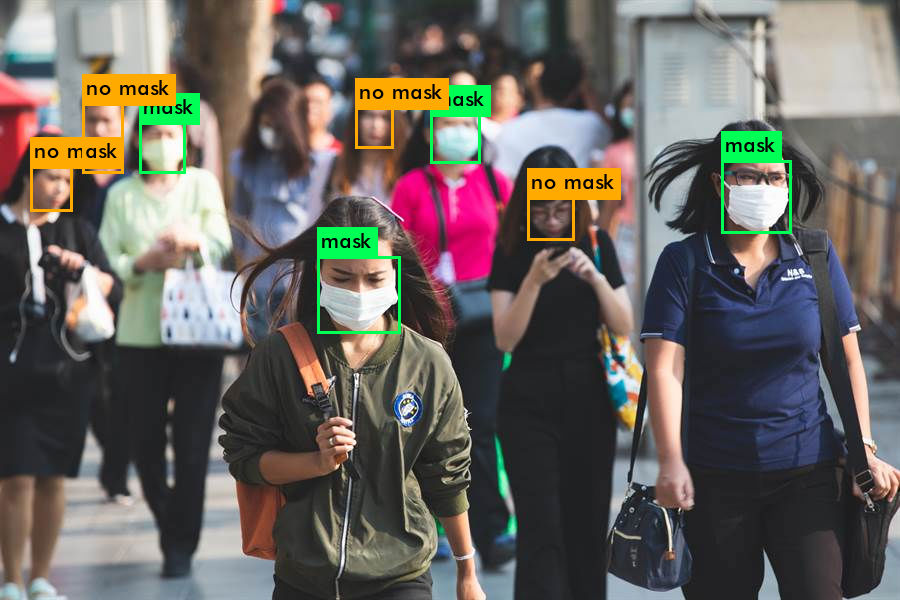

In [26]:
Image.open('/content/darknet/predictions.jpg')

In [29]:
! cd darknet; ./darknet detector test /content/cfg_mask/obj.data  /content/cfg_mask/yolov3.cfg /content/cfg_mask/weights/yolov3.backup /content/test/test_image_4.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

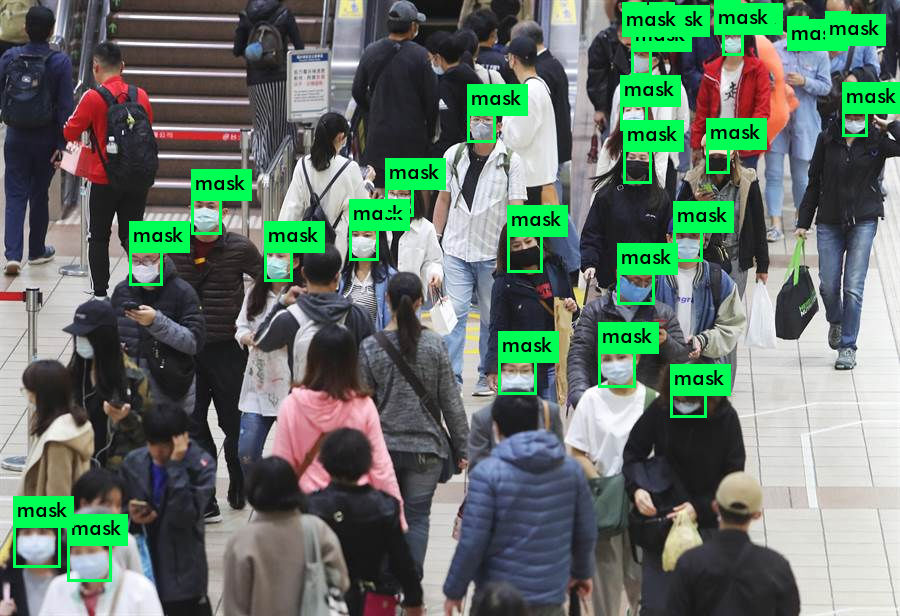

In [30]:
Image.open('/content/darknet/predictions.jpg')